In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from load_data import load_data, Dataset
from config import xvertseg_dir, verse2019_dir, resolution, patch_size

In [2]:
# load data from corresponding data dir
xvertseg_msks, xvertseg_scores = load_data(xvertseg_dir, resolution)
verse2019_msks, verse2019_scores = load_data(verse2019_dir, resolution)

  0%|          | 0/15 [00:00<?, ?it/s]

Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/xvertseg/...


  0%|          | 0/70 [00:00<?, ?it/s]

Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/...


100%|██████████| 70/70 [00:49<00:00,  1.41it/s]


In [3]:
# stack data sets together
msks = np.concatenate((xvertseg_msks, verse2019_msks))
scores = xvertseg_scores.append(verse2019_scores)

In [4]:
# get the valid scores xvert
xvert_scores = xvertseg_scores.to_numpy()[:, 2:].astype(float).reshape(15 * 18, 2)
xvert_scores_valid = xvert_scores[~np.isnan(xvert_scores).any(axis=1)]

# get the valid scores in verse
verse_scores = verse2019_scores.to_numpy()[:, 2:].astype(float).reshape(80 * 18, 2)
verse_scores_valid = verse_scores[~np.isnan(verse_scores).any(axis=1)]

# valid scores in the complete set (xvert + verse)
total_scores = scores.to_numpy()[:, 2:].astype(float).reshape(95 * 18, 2)
scores_valid = total_scores[~np.isnan(total_scores).any(axis=1)]

# count the unique scores in the valid ones
unique_xvers, counts_xvert = np.unique(xvert_scores_valid, return_counts=True, axis=0)
unique_verse, counts_verse = np.unique(verse_scores_valid, return_counts=True, axis=0)
unique_scores, counts_scores = np.unique(scores_valid, return_counts=True, axis=0)

In [5]:
print('{} annotated vertebra in xVertSeg score sheet.'.format(sum(counts_xvert)))
print('{} annotated vertebra in verse score sheet.'.format(sum(counts_verse)))
print('{} annotated vertebra in total in score sheets.'.format(sum(counts_scores)))

75 annotated vertebra in xVertSeg score sheet.
733 annotated vertebra in verse score sheet.
808 annotated vertebra in total in score sheets.


In [6]:
# make a dataset
np_scores = scores.to_numpy()
full_dataset = Dataset(np_scores, msks, patch_size)

Did not find label 8 in the mask as well. Case: verse2019 43
Did not find label 8 in the mask as well. Case: verse2019 64
Did not find label 8 in the mask as well. Case: verse2019 253
Did not find label 9 in the mask as well. Case: verse2019 253
Found a total of 650 in this set


### Statistics about this dataset
Things like:
* distribution of vertebra type
* the frequency of fractures (distribution when we have different cases and grades)

In [7]:
vert_names = np.asarray(['T{}'.format(i) for i in range(1, 13)] + ['L{}'.format(i) for i in range(1, 7)])

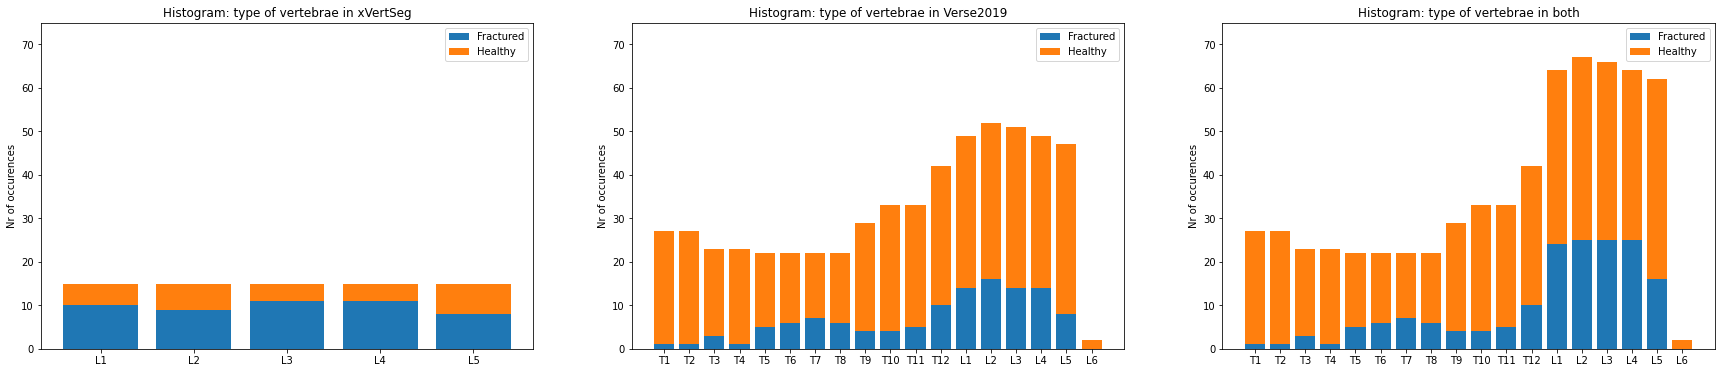

In [8]:
datasets = full_dataset.get_sources()
vertebrae = full_dataset.get_vertebrae()
fractured = full_dataset.get_scores()

ind_xvert = np.argwhere(datasets == 'xvertseg')
ind_verse = np.argwhere(datasets == 'verse2019')
ind_fractured = np.argwhere(fractured)

# fractured counts
_, counts_xvert_frac = np.unique(vertebrae[np.intersect1d(ind_xvert, ind_fractured)], return_counts=True)
_, counts_verse_frac = np.unique(vertebrae[np.intersect1d(ind_verse, ind_fractured)], return_counts=True)
_, counts_both_frac = np.unique(vertebrae[ind_fractured], return_counts=True)

# all counts fractured counts
labels_xvert, counts_xvert = np.unique(vertebrae[ind_xvert], return_counts=True)
labels_verse, counts_verse = np.unique(vertebrae[ind_verse], return_counts=True)
labels_both, counts_both = np.unique(vertebrae, return_counts=True)

# hack but ok
counts_verse_frac = np.append(counts_verse_frac, [0])
counts_both_frac = np.append(counts_both_frac, [0])

counts_xvert_non_frac = counts_xvert - counts_xvert_frac
counts_verse_non_frac = counts_verse - counts_verse_frac
counts_both_non_frac = counts_both - counts_both_frac

plt.figure(figsize=(30, 6))
plt.subplot(1, 3, 1)
plt.bar(labels_xvert, counts_xvert_frac, align='center', label='Fractured')
plt.bar(labels_xvert, counts_xvert_non_frac, align='center', label='Healthy', bottom=counts_xvert_frac)
plt.title('Histogram: type of vertebrae in xVertSeg')
plt.ylabel('Nr of occurences')
plt.legend()
plt.gca().set_xticks(labels_xvert)
plt.gca().set_xticklabels(vert_names[-6:-1])
plt.gca().set_ylim((0, 75))
plt.subplot(1, 3, 2)
plt.bar(labels_verse, counts_verse_frac, align='center', label='Fractured')
plt.bar(labels_verse, counts_verse_non_frac, align='center', label='Healthy', bottom=counts_verse_frac)
plt.title('Histogram: type of vertebrae in Verse2019')
plt.ylabel('Nr of occurences')
plt.legend()
plt.gca().set_xticks(labels_both)
plt.gca().set_xticklabels(vert_names)
plt.gca().set_ylim((0, 75))
plt.subplot(1, 3, 3)
plt.bar(labels_both, counts_both_frac, align='center', label='Fractured')
plt.bar(labels_both, counts_both_non_frac, align='center', label='Healthy', bottom=counts_both_frac)
plt.title('Histogram: type of vertebrae in both')
plt.ylabel('Nr of occurences')
plt.legend()
plt.gca().set_xticks(labels_both)
plt.gca().set_xticklabels(vert_names)
plt.gca().set_ylim((0, 75))
plt.plot
plt.show()